In [1]:
import os
import shutil
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.utils import image_dataset_from_directory

2025-05-17 09:49:57.295099: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747475397.497819      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747475397.556411      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Drop classes by partial match
def drop_classes(dataset_dir, drop_keywords):
    for class_name in os.listdir(dataset_dir):
        for keyword in drop_keywords:
            if keyword.lower() in class_name.lower():
                class_path = os.path.join(dataset_dir, class_name)
                if os.path.isdir(class_path):
                    shutil.rmtree(class_path)
                    print(f"Ὕ Removed: {class_path}")
                else:
                    print(f"⚠️ Not found: {class_path}")

In [3]:
# Get class distribution
def get_class_distribution(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

In [4]:
# Create balanced dataset
def create_balanced_dataset(source_dir, target_dir, drop_keywords):
    os.makedirs(target_dir, exist_ok=True)
    class_counts = get_class_distribution(source_dir)
    remaining_classes = [c for c in class_counts if not any(keyword.lower() in c.lower() for keyword in drop_keywords)]
    if not remaining_classes:
        raise ValueError("No classes remain after dropping specified classes.")
    min_images = min(class_counts[c] for c in remaining_classes)
    print(f"Balancing {target_dir} to {min_images} images per class")

    for class_name in remaining_classes:
        class_path = os.path.join(source_dir, class_name)
        target_class_path = os.path.join(target_dir, class_name)
        os.makedirs(target_class_path, exist_ok=True)

        images = os.listdir(class_path)
        random.shuffle(images)
        selected_images = images[:min_images]
        for img in selected_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(target_class_path, img))
        print(f"Copied {len(selected_images)} images for class {class_name}")

In [5]:
# Random image display
def random_image(val_dir, val_class):
    folder = os.path.join(val_dir, val_class)
    all_images = os.listdir(folder)
    random.shuffle(all_images)
    img_path = os.path.join(folder, all_images[0])
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title(f"{val_class} — {all_images[0]}")
    plt.axis('off')
    plt.show()
    return img

# Check balance
def is_balanced(counts, tolerance=0.1):
    values = list(counts.values())
    avg = sum(values) / len(values)
    return all(abs(v - avg) / avg <= tolerance for v in values)

In [6]:
# Setup paths
src_dataset_path = '/kaggle/input/skin-diseases/kaggle'
dst_dataset_path = '/kaggle/working/skin-diseases'
if not os.path.exists(dst_dataset_path):
    shutil.copytree(src_dataset_path, dst_dataset_path)
    print(f"Dataset copied to: {dst_dataset_path}")

base_path = dst_dataset_path

Dataset copied to: /kaggle/working/skin-diseases


In [7]:

# Drop classes with partial matching
drop_keywords = ['akne', 'pigment']
drop_classes(os.path.join(base_path, 'train'), drop_keywords)
drop_classes(os.path.join(base_path, 'val'), drop_keywords)
drop_classes(os.path.join(base_path, 'test'), drop_keywords)

Ὕ Removed: /kaggle/working/skin-diseases/train/4. Pigment
Ὕ Removed: /kaggle/working/skin-diseases/train/3. Akne
Ὕ Removed: /kaggle/working/skin-diseases/val/4. Pigment
Ὕ Removed: /kaggle/working/skin-diseases/val/3. Akne
Ὕ Removed: /kaggle/working/skin-diseases/test/4. Pigment
Ὕ Removed: /kaggle/working/skin-diseases/test/3. Akne


In [8]:
# Create balanced dataset
create_balanced_dataset(os.path.join(base_path, 'train'), '/kaggle/working/balanced_data/train', drop_keywords)
create_balanced_dataset(os.path.join(base_path, 'val'), '/kaggle/working/balanced_data/val', drop_keywords)
create_balanced_dataset(os.path.join(base_path, 'test'), '/kaggle/working/balanced_data/test', drop_keywords)

Balancing /kaggle/working/balanced_data/train to 4070 images per class
Copied 4070 images for class 1. Enfeksiyonel
Copied 4070 images for class 6. Malign
Copied 4070 images for class 5. Benign
Copied 4070 images for class 2. Ekzama
Balancing /kaggle/working/balanced_data/val to 508 images per class
Copied 508 images for class 1. Enfeksiyonel
Copied 508 images for class 6. Malign
Copied 508 images for class 5. Benign
Copied 508 images for class 2. Ekzama
Balancing /kaggle/working/balanced_data/test to 510 images per class
Copied 510 images for class 1. Enfeksiyonel
Copied 510 images for class 6. Malign
Copied 510 images for class 5. Benign
Copied 510 images for class 2. Ekzama


In [9]:
# Load datasets
train_data = image_dataset_from_directory(
    '/kaggle/working/balanced_data/train',
    label_mode="int",
    image_size=(260, 260),
    batch_size=32,
    shuffle=True,
    seed=42
)
val_data = image_dataset_from_directory(
    '/kaggle/working/balanced_data/val',
    label_mode="int",
    image_size=(260, 260),
    batch_size=32,
    shuffle=False,
    seed=42
)
test_data = image_dataset_from_directory(
    '/kaggle/working/balanced_data/test',
    label_mode="int",
    image_size=(260, 260),
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 16280 files belonging to 4 classes.


I0000 00:00:1747475927.672589      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 2032 files belonging to 4 classes.
Found 2040 files belonging to 4 classes.


In [10]:
# Check distributions
print("Train Distribution:", get_class_distribution('/kaggle/working/balanced_data/train'))
print("Validation Distribution:", get_class_distribution('/kaggle/working/balanced_data/val'))
print("Test Distribution:", get_class_distribution('/kaggle/working/balanced_data/test'))

Train Distribution: {'1. Enfeksiyonel': 4070, '6. Malign': 4070, '5. Benign': 4070, '2. Ekzama': 4070}
Validation Distribution: {'1. Enfeksiyonel': 508, '6. Malign': 508, '5. Benign': 508, '2. Ekzama': 508}
Test Distribution: {'1. Enfeksiyonel': 510, '6. Malign': 510, '5. Benign': 510, '2. Ekzama': 510}


In [11]:
# Callbacks
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=3)

In [12]:
# Augmentation
data_aug = tf.keras.Sequential([
    layers.RandomWidth(0.2),
    layers.RandomHeight(0.2),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomFlip("horizontal_and_vertical"),
])

# Build model with L1 + L2 regularization
l1_l2_reg = regularizers.l1_l2(l1=1e-5, l2=1e-4)


In [13]:
base_model = tf.keras.applications.EfficientNetB3(include_top=False, weights='imagenet')
for layer in base_model.layers[-1:]:
    layer.trainable = True
    
inputs = layers.Input(shape=(260, 260, 3))
x = data_aug(inputs)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation=tf.keras.layers.LeakyReLU(0.2),
                 kernel_initializer='he_normal',
                 kernel_regularizer=l1_l2_reg)(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(4, kernel_regularizer=l1_l2_reg)(x)
outputs = layers.Activation("softmax", dtype='float32')(x)
model = tf.keras.Model(inputs, outputs)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
# Compile and train
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 260, 260, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb3 (Functional)          │ (None, None, None, 1536)    │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           1,028 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 4)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,178,035 (42.64 MB)

 Trainable params: 11,090,732 (42.31 MB)

 Non-trainable params: 87,303 (341.03 KB)

In [15]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/15


E0000 00:00:1747476067.609049      35 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb3_1/block1b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1747476076.415757      84 cuda_dnn.cc:529] Loaded cuDNN version 90300


509/509 ━━━━━━━━━━━━━━━━━━━━ 460s 716ms/step - accuracy: 0.6107 - loss: 1.0875 - val_accuracy: 0.6865 - val_loss: 1.0532 - learning_rate: 0.0010
Epoch 2/15
509/509 ━━━━━━━━━━━━━━━━━━━━ 354s 695ms/step - accuracy: 0.7222 - loss: 0.8021 - val_accuracy: 0.7003 - val_loss: 0.8226 - learning_rate: 0.0010
Epoch 3/15
509/509 ━━━━━━━━━━━━━━━━━━━━ 348s 684ms/step - accuracy: 0.7469 - loss: 0.7038 - val_accuracy: 0.7087 - val_loss: 0.7899 - learning_rate: 0.0010
Epoch 4/15
509/509 ━━━━━━━━━━━━━━━━━━━━ 361s 709ms/step - accuracy: 0.7571 - loss: 0.6405 - val_accuracy: 0.7392 - val_loss: 0.8219 - learning_rate: 0.0010
Epoch 5/15
509/509 ━━━━━━━━━━━━━━━━━━━━ 356s 700ms/step - accuracy: 0.7927 - loss: 0.5602 - val_accuracy: 0.7510 - val_loss: 0.7240 - learning_rate: 0.0010
Epoch 6/15
509/509 ━━━━━━━━━━━━━━━━━━━━ 356s 700ms/step - accuracy: 0.8052 - loss: 0.5239 - val_accuracy: 0.7564 - val_loss: 0.6545 - learning_rate: 0.0010
Epoch 7/15
509/509 ━━━━━━━━━━━━━━━━━━━━ 358s 704ms/step - accuracy: 0.8155 

In [19]:
model.save("/kaggle/working/skin_disease_model.h5")  # Save the entire model


In [22]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points


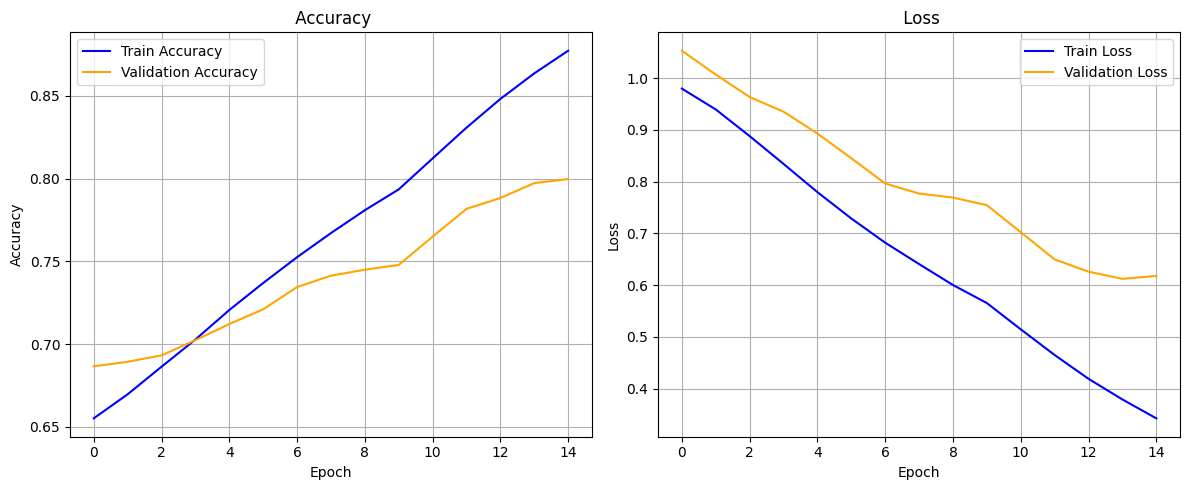

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(smoothed_acc, label='Train Accuracy', color='blue')
plt.plot(smoothed_val_acc, label='Validation Accuracy', color='orange')
plt.title(' Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(smoothed_loss, label='Train Loss', color='blue')
plt.plot(smoothed_val_loss, label='Validation Loss', color='orange')
plt.title(' Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
